In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [4]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 55.1 s


In [5]:
Hterms = (HamiltonianJ6.Hff_m, HamiltonianJ6.HSx_m, HamiltonianJ6.HSy_m, HamiltonianJ6.HSz_m, 
          HamiltonianJ6.HZx_m, HamiltonianJ6.HZy_m, HamiltonianJ6.HZz_m)

# Generating Trajectories and Interpolating Fields
Simple trajectory generating function, simply straight though the lens without any bending to make comparisons simpler

In [6]:
from scipy.interpolate import interp1d

x = np.linspace(0, 0.008, int(np.sqrt(50)))
y = np.linspace(-0.005, 0.005, int(np.sqrt(50)))

def generateTrajectory(x,y):
    tmax = 0.9/200
    t = np.linspace(0,tmax,100)    
    intTrajX = interp1d(t, np.ones(len(t))*x, kind = 'linear')
    intTrajY = interp1d(t, np.ones(len(t))*y, kind = 'linear')
    intTrajZ = interp1d(t, -0.45+t*200, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tmax

In [7]:
import itertools
interpolateTrajectories = []
for xi, yi in itertools.product(x,y):
    interpolateTrajectories.append((generateTrajectory(xi,yi)))

In [8]:
import pickle
with open('trajectoriesStraight_smallregion', 'wb') as wfp:
    pickle.dump(interpolateTrajectories, wfp)

Multiplying the potential of the electrodes by a factor 100 to get a field thats roughly 20 kV/cm. The scale parameter in `fit_potential_xyz` indicates by what factor to multiply the potential

In [9]:
from fields import *
field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0, scale = 100)

funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [10]:
with open('interpolatePotential_homogeneous_100x', 'wb') as wfp:
    pickle.dump((c, intfun, cP, intfunP), wfp)

# Propagation

Some propagation convenience functions

In [11]:
from tqdm import tqdm_notebook as tqdm

def progress_thread(q, total, workers):
    """
    Creating a progress bar using tqdm usable over multiple processes
    """
    done = 0
    pbar = tqdm(total=total)
    while True:
        val = q.get()
        if val != None:
            pbar.update(1)
        else:
            done += 1
        if done == workers:
            pbar.close()
            break

In [12]:
def prepare_ranges(workers, totRange):
    if workers > 1:
        ranges = [(i*int(totRange/(workers)), ((i+1)*int(totRange/(workers)))) for i in range(workers-1)]
        ranges.append((ranges[-1][-1],totRange))
    else:
        ranges = [(0, totRange)]
    return ranges

In [13]:
def combine_multipool(results):
    idT_list, phi0_list, phi_list, H0_list, H_list = [], [], [], [], []
    for idx in range(len(results)):
        idT_list.extend(results[idx][0])
        phi0_list.extend(results[idx][1])
        phi_list.extend(results[idx][2])
        H0_list.extend(results[idx][3])
        H_list.extend(results[idx][4])
    return idT_list, phi0_list, phi_list, H0_list, H_list

In [14]:
import h5py
def save_to_hdf(fname, data):
    idT_list, phi0_list, phi_list, H0_list, H_list = data
    hf = h5py.File(fname, 'w')
    hf.create_dataset('idT', data = idT_list)
    hf.create_dataset('phi0', data = phi0_list)
    hf.create_dataset('phi', data = phi_list)
    hf.create_dataset('H0', data = H0_list)
    hf.create_dataset('H', data = H_list)
    hf.close()
    
def load_from_hdf(fname):
    hf = h5py.File(fname, 'r')
    idT_list = hf['idT'].value
    phi0_list = hf['phi0'].value
    phi_list = hf['phi'].value
    H0_list = hf['H0'].value
    H_list = hf['H'].value
    hf.close()
    return idT_list, phi0_list, phi_list, H0_list, H_list

Some plot convenience functions

In [15]:
from scipy.interpolate import griddata
from matplotlib import colors

def create_grid_trajectories(interpolateTrajectories, probabilities):
    x0 = []
    y0 = []
    for idL in range(len(interpolateTrajectories)):
        traj = interpolateTrajectories[idL]
        x0.append(traj[0](0.000))
        y0.append(traj[1](0.000))
    x0 = np.array(x0)
    y0 = np.array(y0)
    
    dx = np.min(np.abs(np.diff(x0)[np.diff(x0) != 0]))
    dy = np.min(np.abs(np.diff(y0)[np.diff(y0) != 0]))
    
    xi = np.linspace(x0.min(), x0.max(), int(np.sqrt(len(probabilities))))
    yi = np.linspace(y0.min(), y0.max(), int(np.sqrt(len(probabilities))))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x0,y0), probabilities, (X,Y), method = 'linear')
    return x0,y0,xi,yi,X,Y,Z
    
def plot_grid_trajectories(interpolateTrajectories, probabilities):
    x0,y0,xi,yi,X,Y,Z = create_grid_trajectories(interpolateTrajectories, probabilities)
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.imshow(Z, extent = (x0.min(), x0.max(), y0.max(), y0.min()))
    ax.invert_yaxis()
    vmin, vmax = cax.get_clim()
    ax.scatter(x0, y0, c = probabilities, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('probability', fontsize = 15)
    cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
    cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('Probability to stay in state', fontsize = 15);
    ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)
    ax.set_aspect(1/1.35)
    
def plot_trajectory(traj, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, traj[0](t), lw = 3)
    axs[0][1].plot(t, traj[1](t), lw = 3)
    axs[1][0].plot(t, traj[2](t), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'x,y,z'.split(',')):
        ax.set_ylabel(f'{ylabel} [m]')

    fig.delaxes(axs[1][1])
    
def plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, funEx(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[0][1].plot(t, funEy(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][0].plot(t, funEz(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][1].plot(t, funEmag(traj[0](t), traj[1](t), traj[2](t)), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'Ex,Ey,Ez,|E|'.split(',')):
        ax.set_ylabel(f'{ylabel} [V/cm]')
        
def plot_potential_trajectory(traj, intfun, intfunP, c, cP, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
        
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, intfun(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),c), lw = 3)
    axs[0][1].plot(t, intfunP(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),cP), lw = 3)
    axs[1][0].plot(t, intfun(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),c)+
                      intfunP(traj[2](t))*polynomial.polyval2d(traj[0](t), traj[1](t),cP), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'Quadrupole, Homogeneous, Sum'.split(',')):
        ax.set_ylabel(f'{ylabel} [V]')

    fig.delaxes(axs[1][1])
    
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

def Erotation(traj, t):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
    return t[1:], angle, angle/np.diff(t)

def ErotationInit(traj, t):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[0:1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[0:1,:], axis = 1)))
    return t[1:], angle

def plot_field_rotation_trajectory(traj, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
        
    tangle, angle, speed = Erotation(traj, t)
    tangle, angle_init = ErotationInit(traj, t)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(tangle, angle, lw = 3)
    axs[0][1].plot(tangle, speed, lw = 3)
    axs[1][0].plot(tangle, angle_init, lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))

    for ax, ylabel in zip(axs.flat, '[rad],[rad/s],[rad]'.split(',')):
        ax.set_ylabel(f'{ylabel}')

    for ax, title in zip(axs.flat, 'E angle change,E rotational speed,E angle w.r.t. initial E orientation'.split(',')):
        ax.set_title(f'{title}')

    plt.setp(axs[0][0].get_xticklabels(), visible=False)
    axs[0][0].set_xlabel('')

    fig.delaxes(axs[1][1])
    
    ti = tangle[np.argmax(speed)]
    field_max_speed = funEmag(traj[0](ti), traj[1](ti), traj[2](ti))
    print(f'field max rotation speed : {field_max_speed:.2e} V/cm @{ti:.2e} s')
    
from scipy.interpolate import griddata

def plot_E_xyplane(traj):
    t = np.linspace(0,traj[-1],10000)
    xi, yi = np.linspace(-0.01, 0.01, 1000), np.linspace(-0.01, 0.01, 1000)
    X,Y = np.meshgrid(xi,yi)
    tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
    print(tmin)
    Z = funEmag(X,Y,traj[2](tmin))

    # from matplotlib import colors
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
    vmin, vmax = cax.get_clim()
    ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('|E| [V/cm]', fontsize = 15)
    # cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('|E| @ minimum for trajectory', fontsize = 15);
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)
    
def plot_Ez_xyplane(traj):
    t = np.linspace(0,traj[-1],10000)
    xi, yi = np.linspace(-0.01, 0.01, 200), np.linspace(-0.01, 0.01, 200)
    X,Y = np.meshgrid(xi,yi)
    tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
    Z = funEz(X,Y,traj[2](tmin))

    # from matplotlib import colors
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
    vmin, vmax = cax.get_clim()
    ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('|E| [V/cm]', fontsize = 15)
    # cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('Ez @ minimum for trajectory', fontsize = 15);
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)

## Multiprocessing Propagation

In [ ]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 4
# level to propagate
start_level = 35
# total trajectories
nrTrajectories = len(interpolateTrajectories)

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesStraight_smallregion', 'interpolatePotential_homogeneous_100x', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [ ]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [ ]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities_straight_20kV_20G_5cm.h5'
save_to_hdf(data_dir+fname, (idT_list, phi0_list, phi_list, H0_list, H_list))

In [47]:
# data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
data_dir = ''
fname = 'calculatedProbabilities_straight_20kV_20G_5cm.h5'
idT_list, phi0_list, phi_list, H0_list, H_list = load_from_hdf(data_dir+fname)

0.8782740263048288


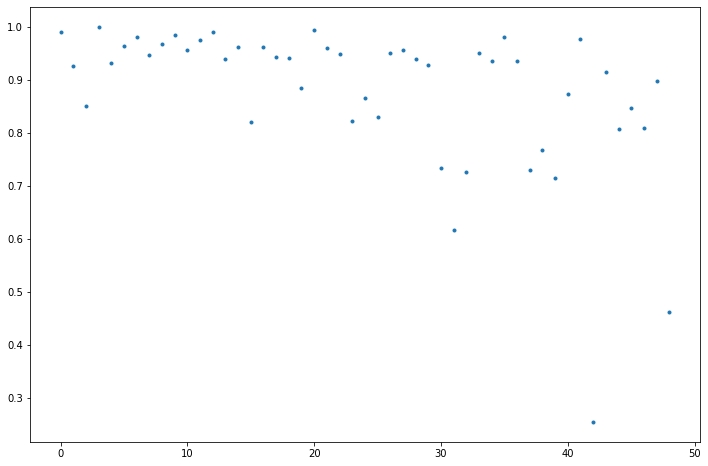

In [48]:
tmp = []
for idL in range(len(interpolateTrajectories)):
    tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)
    
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(tmp, '.')
print(np.mean(tmp))

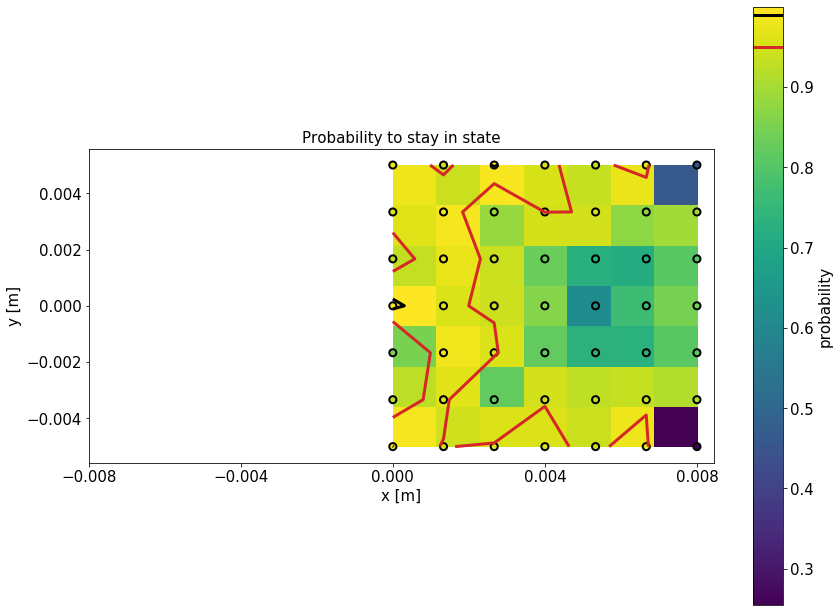

In [81]:
plot_grid_trajectories(interpolateTrajectories, tmp)

In [92]:
for idx in np.argsort(tmp):
    x,y = interpolateTrajectories[idx][0](0), interpolateTrajectories[idx][1](0)
    print(f'{idx}, ({x:.2e},{y:.2e}), P = {tmp[idx]*100:.0f}%')
del idx, x, y

42, (8.00e-03,-5.00e-03), P = 26%
48, (8.00e-03,5.00e-03), P = 46%
31, (5.33e-03,0.00e+00), P = 62%
39, (6.67e-03,1.67e-03), P = 72%
32, (5.33e-03,1.67e-03), P = 73%
37, (6.67e-03,-1.67e-03), P = 73%
30, (5.33e-03,-1.67e-03), P = 73%
38, (6.67e-03,0.00e+00), P = 77%
44, (8.00e-03,-1.67e-03), P = 81%
46, (8.00e-03,1.67e-03), P = 81%
15, (2.67e-03,-3.33e-03), P = 82%
23, (4.00e-03,-1.67e-03), P = 82%
25, (4.00e-03,1.67e-03), P = 83%
45, (8.00e-03,0.00e+00), P = 85%
2, (0.00e+00,-1.67e-03), P = 85%
24, (4.00e-03,0.00e+00), P = 87%
40, (6.67e-03,3.33e-03), P = 87%
19, (2.67e-03,3.33e-03), P = 88%
47, (8.00e-03,3.33e-03), P = 90%
43, (8.00e-03,-3.33e-03), P = 92%
1, (0.00e+00,-3.33e-03), P = 93%
29, (5.33e-03,-3.33e-03), P = 93%
4, (0.00e+00,1.67e-03), P = 93%
34, (5.33e-03,5.00e-03), P = 93%
36, (6.67e-03,-3.33e-03), P = 94%
28, (5.33e-03,-5.00e-03), P = 94%
13, (1.33e-03,5.00e-03), P = 94%
18, (2.67e-03,1.67e-03), P = 94%
17, (2.67e-03,0.00e+00), P = 94%
7, (1.33e-03,-5.00e-03), P = 95%
2

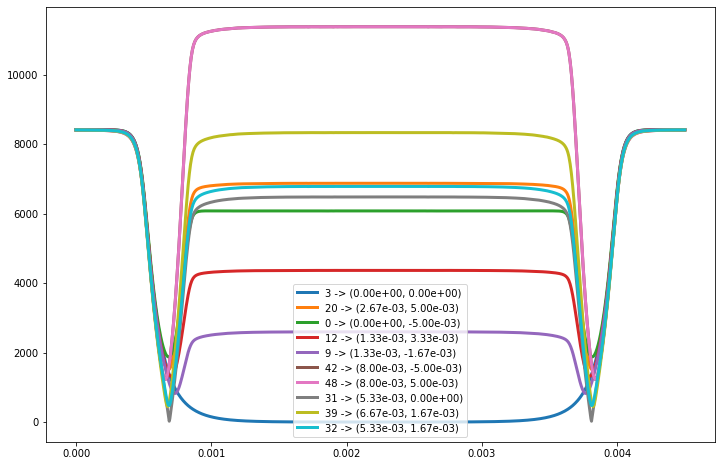

In [105]:
t = np.linspace(0, 0.0045, 1000)
fig, ax = plt.subplots(figsize = (12,8))
for idx in np.argsort(tmp)[::-1][:5]:
    x,y = interpolateTrajectories[idx][0](0), interpolateTrajectories[idx][1](0)
    ax.plot(t, funEmag(interpolateTrajectories[idx][0](t), interpolateTrajectories[idx][1](t), interpolateTrajectories[idx][2](t)), lw = 3,
           label = f'{idx} -> ({x:.2e}, {y:.2e})')
for idx in np.argsort(tmp)[:5]:
    x,y = interpolateTrajectories[idx][0](0), interpolateTrajectories[idx][1](0)
    ax.plot(t, funEmag(interpolateTrajectories[idx][0](t), interpolateTrajectories[idx][1](t), interpolateTrajectories[idx][2](t)), lw = 3,
           label = f'{idx} -> ({x:.2e}, {y:.2e})')
ax.legend()
del t, idx, x, y

## Looping over multiple homogeneous field strengths

In [17]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

from fields import *
field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
data_dir = ''
for scale in [1,20,40,60,80,100,120,140,160,180]:
    cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0, scale = scale)
    with open(f'interpolatePotential_homogeneous_{scale}x', 'wb') as wfp:
        pickle.dump((c, intfun, cP, intfunP), wfp)

    funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

    # set # cores to utilize
    nrCores = 4
    # level to propagate
    start_level = 35
    # total trajectories
    nrTrajectories = len(interpolateTrajectories)

    ranges = prepare_ranges(nrCores,nrTrajectories)

    if __name__ == '__main__':
        m = multiprocessing.Manager()
        q = m.Queue()
        progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
        progress.start()

        args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesStraight_smallregion', f'interpolatePotential_homogeneous_{scale}x', q) \
                 for r in ranges]

        pool = multiprocessing.Pool(processes = nrCores)
        result = pool.map(propagate_multi, args)
        pool.close()
        pool.join()
        
    idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)
    fname = f'calculatedProbabilities_straight_{84*scale}V/cm_20G_5cm.h5'
    save_to_hdf(data_dir+fname, (idT_list, phi0_list, phi_list, H0_list, H_list))
    
    tmp = []
    for idL in range(len(interpolateTrajectories)):
        tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)

    plot_grid_trajectories(interpolateTrajectories, tmp)

KeyboardInterrupt: 